lets expand our standard {'head/layout' : 'f'} to {'head/layout' : 'fa f'} for better performance
<br>
obviously, it includes (structurally) layout for basic logistic regression
<br>
and thus should work at least not worse

In [13]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import progressbar
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../../batchflow')

from batchflow import B, V, C, Pipeline, Config
from batchflow.models.metrics import ClassificationMetrics
from batchflow.models.torch.layers import Dense
from batchflow.models.torch import TorchModel
from batchflow.opensets import MNIST
from batchflow import best_practice

from IPython.display import clear_output
from time import sleep

In [2]:
BATCH_SIZE = 64
mnist = MNIST()

DownloadingExtracting http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Extracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/train-images-idx3-ubyte.gz
ExtractingExtracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/t10k-labels-idx1-ubyte.gz
 /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/train-labels-idx1-ubyte.gz
 /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/t10k-images-idx3-ubyte.gz


In [48]:
model_config_f = {
    'inputs': dict(images={'shape': (1, 28, 28),
                           'data_format': 'channels_first'},
                   labels={'classes': 10}),
    'loss': 'ce',
    'optimizer': 'Adam',
    'initial_block/inputs': 'images',
    'body/units': 10,
    'body/layout': 'f',
    'output': dict(predicted=['proba', 'labels'])
}

model_config_ff = model_config_f + Config({'body/layout' : 'fa f'})

configs = [model_config_f, model_config_ff]

In [4]:
train_pipelines = []

for i, config in enumerate(configs):
    
    train_template = (Pipeline()
    .init_variable('loss_history', init_on_each_run=list)
    .init_model('dynamic', TorchModel, 'model', config)
    .to_array('float32', 'channels_first')
    .train_model('model', B('images'), B('labels'), fetches='loss', save_to=V('loss_history'), mode='a'))
    
    train_pipelines.append(train_template << mnist.train)
    
for pipeline in train_pipelines:
    pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, bar=True)

100%|█████████▉| 937/938 [00:06<00:00, 144.06it/s]


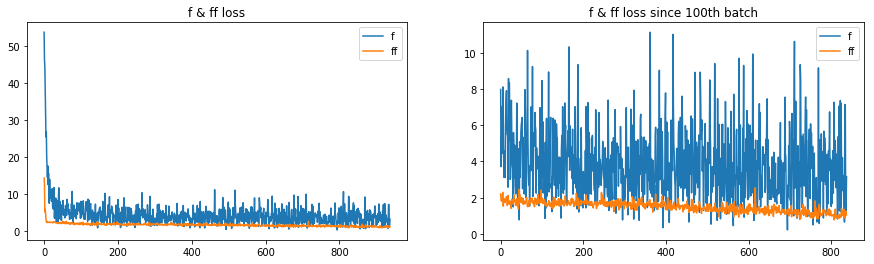

In [6]:
fig = plt.figure(figsize=(15,4))

shifts = [0, 100]
titles = ['f & ff loss', f'f & ff loss since {shifts[1]}th batch']
legend = ['f', 'ff']
lines = 1
cols = 2
num = lines * cols

for i in range(num):
    plt.subplot(lines, cols, i+1)
    for pipeline in train_pipelines:
        plt.plot(pipeline.get_variable('loss_history')[shifts[i]:])
        plt.title(titles[i])
        plt.legend(legend)
        
plt.show()

yeah, ff converges much better

In [7]:
test_pipelines = []

for i, config in enumerate(configs):
    
    test_template = (Pipeline()
    .init_variable('predictions')
    .init_variable('metrics')
    .import_model('model', train_pipelines[i])
    .to_array('float32', 'channels_first')
    .predict_model('model', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions'), mode='w')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=1, save_to=V('metrics'), mode='u'))
    
    test_pipelines.append(test_template << mnist.test)
    
for pipeline in test_pipelines:
    pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, bar=True)

 99%|█████████▉| 156/157 [00:00<00:00, 195.19it/s]


In [8]:
legend = ['f', 'ff']

for i, pipeline in enumerate(test_pipelines):
    metrics = pipeline.get_variable('metrics')
    print(legend[i], 'accuracy:', metrics.accuracy(), '\n\n', metrics._confusion_matrix, '\n\n')

f accuracy: 0.8863 

 [[[ 941    0    6    4    1   11    8    1    7    7]
  [   0 1119   19    3    9    4    3   18   42   14]
  [  10    3  935   31    7    4   14   40   23    2]
  [   3    2   15  856    1   18    2    7   27   13]
  [   1    0   14    5  924   23   12   13   45  142]
  [   9    4    4   78    3  789   13    1   94   26]
  [  11    3   11    4   15   18  905    0   15    0]
  [   1    1    5    8    4    2    0  918   10   33]
  [   4    3   21   17    5   21    1    5  708    4]
  [   0    0    2    4   13    2    0   25    3  768]]] 


ff accuracy: 0.5952 

 [[[ 890    0    1    0    0    4    3   18    1    4]
  [   0 1101    4    0    0    2    2    5   27    1]
  [   1    0  634   28    2    0    3    7    1    0]
  [   0    5  282  621    1   29    1   20   18    1]
  [   0    0   12    0  900    5    8   77    4  748]
  [   1    0    1    1    0    1    1    0    1    0]
  [   9    4   37    7   19   12  885    2   14    1]
  [  77   16   58  349   26  832

ehm

well, this is shit

what went wrong?
<br>
lets rerun model and observe how it performs on test during train process

In [18]:
train_pipelines = []
test_pipelines = []

for i, config in enumerate(configs):
    
    train_template = (Pipeline()
    .init_variable('loss_history', init_on_each_run=list)
    .init_model('dynamic', TorchModel, 'model', config)
    .to_array('float32', 'channels_first')
    .train_model('model', B('images'), B('labels'), fetches='loss', save_to=V('loss_history'), mode='a'))
    
    train_pipelines.append(train_template << mnist.train)
    
    test_template = (Pipeline()
    .init_variable('predictions')
    .init_variable('metrics', init_on_each_run=None)
    .import_model('model', train_pipelines[i])
    .to_array('float32', 'channels_first')
    .predict_model('model', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions'), mode='w')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=1, save_to=V('metrics'), mode='u'))
    
    test_pipelines.append(test_template << mnist.test)

In [19]:
accuracies = []
for i in range(len(configs)):
    accuracies.append(list())

batches = 10000
bar = progressbar.ProgressBar(maxval=batches, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

for i in range(batches):
    for j, pipeline in enumerate(train_pipelines):
        pipeline.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None)
        if (i+1) % 100 == 0:
            test_pipelines[j].run(BATCH_SIZE, n_epochs=1)
            accuracies[j].append(test_pipelines[j].get_variable('metrics').evaluate('accuracy'))
    bar.update(i+1)
    sleep(0.0001)

bar.finish()

[========================================================================] 100%


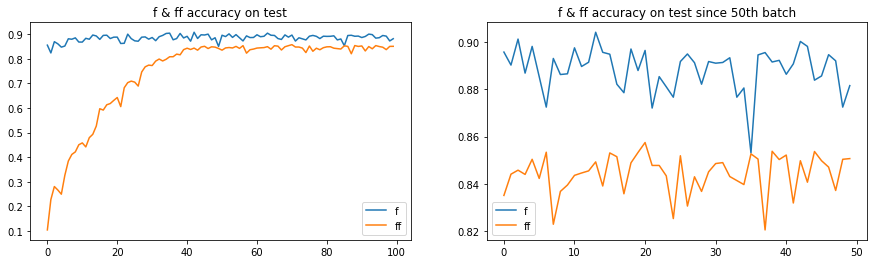

In [21]:
fig = plt.figure(figsize=(15,4))

shifts = [0, 50]
titles = ['f & ff accuracy on test', f'f & ff accuracy on test since {shifts[1]}th batch']
legend = ['f', 'ff']
lines = 1
cols = 2
num = lines * cols

for i in range(num):
    plt.subplot(lines, cols, i+1)
    for accuracy in accuracies:
        plt.plot(accuracy[shifts[i]:])
        plt.title(titles[i])
        plt.legend(legend)
        
plt.show()

okay, basically it converges
<br>
sometimes
<br>
but MUCH SLOWER comparible to classic logistic regression
<br>
why?

In [23]:
train_pipelines[1].get_model_by_name('model').model[0]

ConvBlock(
  (block): Sequential(
    (0): Dense(
      (linear): Linear(in_features=784, out_features=10, bias=True)
    )
    (1): Activation(
      (activation): ReLU(inplace)
    )
    (2): Dense(
      (linear): Linear(in_features=10, out_features=10, bias=True)
    )
  )
)

out_features = 10 of the first dense layer seems a bit confusing
<br>
and yes, it is the reason why ff learns so bad
<br>
most of the weights (avg 7-8 of 10) are negative before the ReLU
<br>
and thus it converts them to zero and second dense layer gets only 2-3 non-zero values
<br>
after beeing stuck on this "zero-plateu" it takes a few epochs to leave it, since everything model has is that non-zero neurons

so, there are at least 3 ways to avoid this situation:

In [49]:
model_config_ff_more_units = model_config_ff + Config({'body/units' : [100,10]})
model_config_ff_change_activation = model_config_ff + Config({'body/activation' : 'LeakyRelu'})
model_config_ff_add_normalization = model_config_ff + Config({'body/layout' : 'fan f'})
configs += [model_config_ff_more_units, model_config_ff_change_activation, model_config_ff_add_normalization]

In [51]:
train_pipelines = []
test_pipelines = []

for i, config in enumerate(configs):
    
    train_template = (Pipeline()
    .init_variable('loss_history', init_on_each_run=list)
    .init_model('dynamic', TorchModel, 'model', config)
    .to_array('float32', 'channels_first')
    .train_model('model', B('images'), B('labels'), fetches='loss', save_to=V('loss_history'), mode='a'))
    
    train_pipelines.append(train_template << mnist.train)
    
    test_template = (Pipeline()
    .init_variable('predictions')
    .init_variable('metrics', init_on_each_run=None)
    .import_model('model', train_pipelines[i])
    .to_array('float32', 'channels_first')
    .predict_model('model', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions'), mode='w')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=1, save_to=V('metrics'), mode='u'))
    
    test_pipelines.append(test_template << mnist.test)

In [52]:
accuracies = []
for i in range(len(configs)):
    accuracies.append(list())

batches = 4000
bar = progressbar.ProgressBar(batches, [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

for i in range(batches):
    for j, pipeline in enumerate(train_pipelines):
        pipeline.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None)
        if (i+1) % 100 == 0:
            test_pipelines[j].run(BATCH_SIZE, n_epochs=1)
            accuracies[j].append(test_pipelines[j].get_variable('metrics').evaluate('accuracy'))
    bar.update(i+1)
    sleep(0.0001)

bar.finish()

[========================================================================] 100%


In [53]:
loss_histories = []
for pipeline in train_pipelines:
    loss_histories.append(pipeline.get_variable('loss_history'))

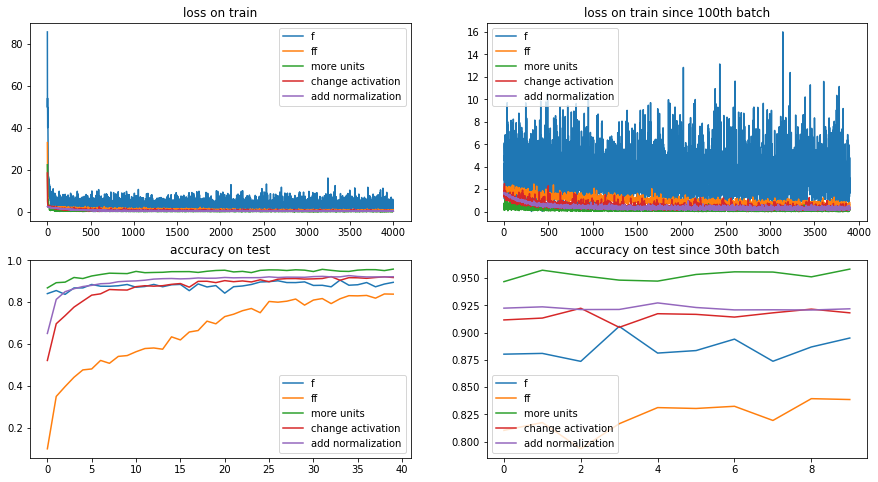

In [55]:
fig = plt.figure(figsize=(15,8))
variations  = ['f', 'ff', 'more units', 'change activation', 'add normalization']
shifts = [0, 100, 0, 30]
titles = ['loss on train', f'loss on train since {shifts[1]}th batch',
          'accuracy on test', f'accuracy on test since {shifts[3]}th batch']
lines = 2
cols = 2
num = lines * cols

for i in range(num):
    plt.subplot(lines, cols, i+1)
    if i in (0,1):
        for loss in loss_histories:
            plt.plot(loss[shifts[i]:])
    elif i in (2,3):
        for accuracy in accuracies:
            plt.plot(accuracy[shifts[i]:])
    plt.title(titles[i])
    plt.legend(variations)
        
plt.show()

In [56]:
for i, pipeline in enumerate(test_pipelines):
    metrics = pipeline.get_variable('metrics')
    print(variations[i], 'accuracy:', metrics.accuracy(), '\n\n', metrics._confusion_matrix, '\n\n')

f accuracy: 0.895 

 [[[ 932    0    4    2    0    8   10    2    4    5]
  [   0 1106    6    1    2    3    3    6    8    6]
  [   2    8  901   18    8    2   17   28    6    0]
  [   3    5   42  948    4   73    7   26   45   19]
  [   2    0   12    0  885    6    9    5    6   34]
  [  21    2   16   14    3  722   45    2   44    9]
  [   5    1    2    0    3    5  851    1    2    1]
  [   7    2    5    2    7    6    0  883    7   25]
  [   8   11   42   22   34   62   16   11  849   37]
  [   0    0    2    3   36    5    0   64    3  873]]] 


ff accuracy: 0.8386 

 [[[ 901    0   10    1    2   34   39    1  102   11]
  [   0 1102    3    0    0    1    2    5   13    4]
  [   0    3  865   21    8    4   47   19   13    0]
  [   0    9   20  885    5   89    0    4   31   24]
  [   2    2   19    6  854   14    4    8   48   74]
  [   0    2    7   61    0  646    8    0   77   10]
  [  17    1   60    6    2    6  821    0   13    1]
  [   6    0    9   10    2    3 

thats better